In [1]:
import csv
import numpy as np
import pylandau
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import random

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
with open('clean_pion_root.txt') as f:
    lines = f.readlines()
    fileColumn1 = np.array([line.split()[0] for line in lines])
    fileColumn2 = np.array([line.split()[1] for line in lines])

pionRoot1 = fileColumn1.astype(float)
pionRoot2 = fileColumn2.astype(float)

In [3]:
with open('clean_pion_length_angle_root.txt') as f:
    lines = f.readlines()
    fileColumn1 = np.array([line.split()[0] for line in lines])
    fileColumn2 = np.array([line.split()[1] for line in lines])

PI_length = fileColumn1.astype(float)
PI_cos = fileColumn2.astype(float)

In [4]:
with open('clean_muon_root.txt') as f:
    lines = f.readlines()
    fileColumn1 = np.array([line.split()[0] for line in lines])
    fileColumn2 = np.array([line.split()[1] for line in lines])

muonRoot1 = fileColumn1.astype(float)
muonRoot2 = fileColumn2.astype(float)

In [5]:
with open('clean_muon_length_angle_root.txt') as f:
    lines = f.readlines()
    fileColumn1 = np.array([line.split()[0] for line in lines])
    fileColumn2 = np.array([line.split()[1] for line in lines])

MU_length = fileColumn1.astype(float)
MU_cos = fileColumn2.astype(float)

In [6]:
mu_I_remove1 = np.where(muonRoot1 < 0.001)[0]
muonRoot1 = np.delete(muonRoot1, mu_I_remove1)
muonRoot2 = np.delete(muonRoot2, mu_I_remove1)
MU_length = np.delete(MU_length, mu_I_remove1)
MU_cos = np.delete(MU_cos, mu_I_remove1)

mu_I_remove2 = np.where(muonRoot2 < 0.001)[0]
muonRoot1 = np.delete(muonRoot1, mu_I_remove2)
muonRoot2 = np.delete(muonRoot2, mu_I_remove2)
MU_length = np.delete(MU_length, mu_I_remove2)
MU_cos = np.delete(MU_cos, mu_I_remove2)

mu_I_remove12 = np.where(muonRoot1 > 150)[0]
muonRoot1 = np.delete(muonRoot1, mu_I_remove12)
muonRoot2 = np.delete(muonRoot2, mu_I_remove12)
MU_length = np.delete(MU_length, mu_I_remove12)
MU_cos = np.delete(MU_cos, mu_I_remove12)

mu_I_remove22 = np.where(muonRoot2 > 900)[0]
muonRoot1 = np.delete(muonRoot1, mu_I_remove22)
muonRoot2 = np.delete(muonRoot2, mu_I_remove22)
MU_length = np.delete(MU_length, mu_I_remove22)
MU_cos = np.delete(MU_cos, mu_I_remove22)

In [7]:
pi_I_remove1 = np.where(pionRoot1 < 0.001)[0]
pionRoot1 = np.delete(pionRoot1, pi_I_remove1)
pionRoot2 = np.delete(pionRoot2, pi_I_remove1)
PI_length = np.delete(PI_length, pi_I_remove1)
PI_cos = np.delete(PI_cos, pi_I_remove1)

pi_I_remove2 = np.where(pionRoot2 < 0.001)[0]
pionRoot1 = np.delete(pionRoot1, pi_I_remove2)
pionRoot2 = np.delete(pionRoot2, pi_I_remove2)
PI_length = np.delete(PI_length, pi_I_remove2)
PI_cos = np.delete(PI_cos, pi_I_remove2)

pi_I_remove12 = np.where(pionRoot1 > 150)[0]
pionRoot1 = np.delete(pionRoot1, pi_I_remove12)
pionRoot2 = np.delete(pionRoot2, pi_I_remove12)
PI_length = np.delete(PI_length, pi_I_remove12)
PI_cos = np.delete(PI_cos, pi_I_remove12)

pi_I_remove22 = np.where(pionRoot2 > 900)[0]
pionRoot1 = np.delete(pionRoot1, pi_I_remove22)
pionRoot2 = np.delete(pionRoot2, pi_I_remove22)
PI_length = np.delete(PI_length, pi_I_remove22)
PI_cos = np.delete(PI_cos, pi_I_remove22)

In [8]:
temp_i = 1
IndexM = [0]

while temp_i < len(muonRoot1):
    if muonRoot1[temp_i-1] > muonRoot1[temp_i]:
        IndexM.append(temp_i)
    temp_i+=1

In [9]:
temp_i = 1
IndexPI = [0]

while temp_i < len(pionRoot1):
    if pionRoot1[temp_i-1] > pionRoot1[temp_i]:
        IndexPI.append(temp_i)
    temp_i+=1

In [10]:
import numpy as np

Z = 18
A = 39.948   # g / mol
I = 188.0*(10**(-6)) # MeV
K = 0.307 # MeV * cm^2 / mol
Mmu = 105.658 # MeV for muon
Me  = 0.51 # MeV for electron
rho = 1.396 # g/cm3

m_MU = 105.7
m_P = 938.272
m_Pi = 139.6

def beta(gamma):
    return np.sqrt(1-(1./(gamma**2)))

def gamma(KE,mass):
    return (KE/mass)+1

beta = np.vectorize(beta)
gamma = np.vectorize(gamma)

def Wmax (KE,mass):
    g = gamma(KE,mass)
    b = beta(g)
    num = 2*Me*((b*g)**2)
    den = 1 + 2*g*Me/mass + (Me/mass)**2
    return num/den

# density correction for LAr
def density(bg):

    # constants and variable names obtained from :
    # PDG elos muons table [http://pdg.lbl.gov/2016/AtomicNuclearProperties/MUE/muE_liquid_argon.pdf]
    
    C  = -5.2146
    X0 = 0.2
    X1 = 3.0
    a  = 0.19559
    m  = 3.0
    N    = 2 * np.log(10)
    
    x = np.log10(bg)
    
    if (x < X0):
        return 0.
    if (x > X1):
        return N * x + C
    addition = a*((X1-x)**m)
    return N * x + C + addition

class Eloss:

    def __init__(self,I=188,rho=1.38):
        self.I   = I   # mean excitation energy [eV]
        self.rho = rho # argon density [g/cm3]

    # set density [input in g/cm3]
    def setDensity(rho):
        self.rho = rho

    # set mean excitation energy I [input in eV]
    def setI(I):
        self.I = I

    # print argon properties currently loaded
    def PrintArInfo():
        print
        print('Argon density .............. : %.03f g/cm3')%self.rho
        print('Argon mean excitation energy : %.03f eV')%self.I
        print
        
# KE in MeV
# x in cm
# mass in MeV
def dpdx(KE,x,mass,I=I):
    g = gamma(KE,mass)
    b = beta(g)
    epsilon = (K/2.)*(Z/A)*(x*rho/(b*b))
    A0 = (2*Me*(b*g)**2)/I
    A1 = epsilon/I
    return (1./x) * epsilon * (np.log(A0) + np.log(A1) + 0.2 - (b*b) - density(b*g))

# in MeV/cm
def dedx(KE,mass,I=I,dens=True):
    g = gamma(KE,mass)
    b = beta(g)
    F = K * (Z/A)*(1/b)**2
    wmax = Wmax(KE,mass)
    a0 = 0.5*np.log( 2*Me*(b*g)**2 * wmax / (I*I) )
    ret = a0 - b*b
    if (dens == True):
        ret -= density(b*g)/2.
    return F * ret


def Tfunc(g):
    return (g-1.)*Me
def tfunc(g):
    return (g-1.)

def Fminus(b,t):
    f = (1-b*b) * ( 1 + t*t/8. - (2*t+1)*np.log(2) )
    return f
def Fplus(b,t):
    f = 2*np.log(2) - (b*b/12.) * ( 23. + 14./(t+2.) + 10./(t+2.)**2 + 4./(t+2.)**3 )
    return f

def dedxelectrons(beta,dens=True):
    g = 1./np.sqrt(1-beta*beta)
    T = Tfunc(g)
    t = tfunc(g)
    F = (Z/A) * 0.153536 * ((1./beta)**2)
    ret =  (np.log((T/I)**2)) + np.log(1.+t/2.) + Fminus(beta,t)
    if (dens == True):
        ret -= density(beta*g)
    return ret * F

def dedxpositrons(beta,dens=True):
    g = 1./np.sqrt(1-beta*beta)
    T = Tfunc(g)
    t = tfunc(g)
    F = (Z/A) * 0.153536 * ((1./beta)**2)
    ret =   (np.log((T/I)**2)) + np.log(1+t/2.) + Fplus(beta,t)
    if (dens == True):
        ret -= density(beta*g)
    return ret * F

In [11]:
def EtoRR(energy, mass):
    RR = 0
    while energy > 0:
        energy = energy - dpdx(energy, 0.3, mass) * 0.3
        RR = RR + 0.3

    return RR

In [14]:
def todEdx(dQdx):
    dQdx = dQdx*200
    return dQdx/(((0.8*10**6)/23.6)-0.0486*dQdx/0.273)

In [15]:
KEvals = np.linspace(1, 500., 500)
dedxvals = []
dedxvalsp = []
dedxvalspi = []
for KE in KEvals:
    dedxvals.append(dpdx(KE, 0.3, m_MU))
    dedxvalsp.append(dpdx(KE, 0.3, m_P))
    dedxvalspi.append(dpdx(KE, 0.3, m_PI))

In [17]:
from scipy.interpolate import UnivariateSpline

fit_E_pi = np.linspace(0, 500, 10)
fit_RR_pi = []
for KE in fit_E_pi:
    if(KE==0):
        fit_RR_pi.append(0)
    else:
        fit_RR_pi.append(EtoRR(KE, m_PI))

interp_func_pi = UnivariateSpline(fit_RR_pi, fit_E_pi)

In [18]:
fit_E_mu = np.linspace(0, 500, 10)
fit_RR_mu = []
for KE in fit_E_mu:
    if(KE==0):
        fit_RR_mu.append(0)
    else:
        fit_RR_mu.append(EtoRR(KE, m_MU))

interp_func_mu = UnivariateSpline(fit_RR_mu, fit_E_mu)

In [19]:
muonCvt1 = interp_func_mu(muonRoot1)
muonCvt2 = todEdx(muonRoot2)

pionCvt1 = interp_func_pi(pionRoot1)
pionCvt2 = todEdx(pionRoot2)

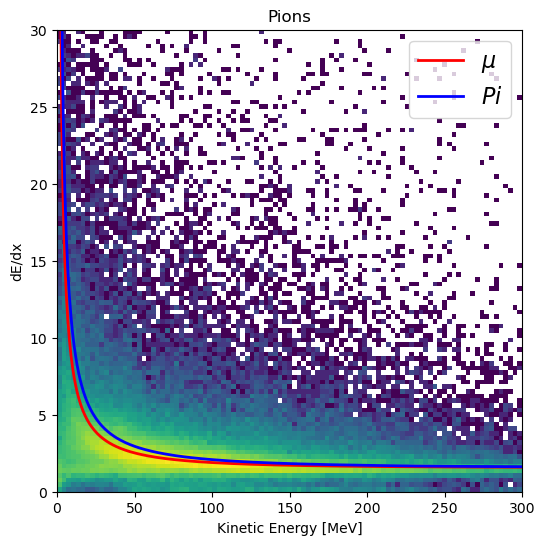

In [20]:
fig = plt.figure(figsize=(6,6))
BINS2D = (np.linspace(0,300,100),np.linspace(0,30,100))
plt.plot(KEvals,dedxvals,color='r',lw=2,label='$μ$')
plt.plot(KEvals,dedxvalspi,color='b',lw=2,label='$Pi$')
plt.legend(loc=1,fontsize=16)
plt.hist2d(pionCvt1,pionCvt2,bins=BINS2D,norm=colors.LogNorm())
plt.xlabel('Kinetic Energy [MeV]')
plt.ylabel('dE/dx')
plt.title('Pions')
plt.show()

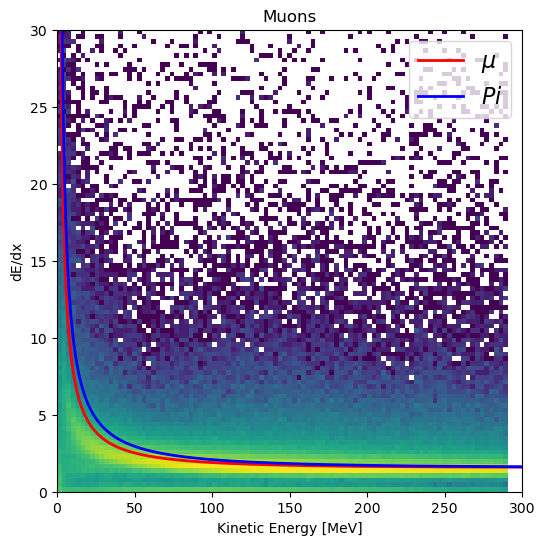

In [21]:
fig = plt.figure(figsize=(6,6))
BINS2D = (np.linspace(0,300,100),np.linspace(0,30,100))
plt.plot(KEvals,dedxvals,color='r',lw=2,label='$μ$')
plt.plot(KEvals,dedxvalspi,color='b',lw=2,label='$Pi$')
plt.legend(loc=1,fontsize=16)
plt.hist2d(muonCvt1,muonCvt2,bins=BINS2D,norm=colors.LogNorm())
plt.xlabel('Kinetic Energy [MeV]')
plt.ylabel('dE/dx')
plt.title('Muons')
plt.show()

In [ ]:
# Compute the likelihood ratio test statistics

probabilityList = []
eta, sigma = 1, 0.8

for i, ele in enumerate(muonCvt2):
    mpv = dpdx(muonCvt1[i], 0.3, m_MU)
    temp_x = np.arange(0, mpv+50, 0.03)
    temp_y = pylandau.langau(temp_x, mpv, eta, sigma, 1)
    probabilityList.append(np.interp(ele, temp_x, temp_y))

In [ ]:
probabilityListMu_Pi = []
eta, sigma = 1, 0.8

for i, ele in enumerate(muonCvt2):
    mpv = dpdx(muonCvt1[i], 0.3, m_PI)
    temp_x = np.arange(0, mpv+50, 0.03)
    temp_y = pylandau.langau(temp_x, mpv, eta, sigma, 1)
    probabilityListMu_Pi.append(np.interp(ele, temp_x, temp_y))

In [ ]:
probabilityListPi_Pi = []
eta, sigma = 1, 0.8

for i, ele in enumerate(pionCvt2):
    mpv = dpdx(pionCvt1[i], 0.3, m_PI)
    temp_x = np.arange(0, mpv+50, 0.03)
    temp_y = pylandau.langau(temp_x, mpv, eta, sigma, 1)
    probabilityListPi_Pi.append(np.interp(ele, temp_x, temp_y))

In [ ]:
probabilityListPi_Mu = []
eta, sigma = 1, 0.8

for i, ele in enumerate(pionCvt2):
    mpv = dpdx(pionCvt1[i], 0.3, m_MU)
    temp_x = np.arange(0, mpv+50, 0.03)
    temp_y = pylandau.langau(temp_x, mpv, eta, sigma, 1)
    probabilityListPi_Mu.append(np.interp(ele, temp_x, temp_y))

In [26]:
# select last 20 cm of each track

over_MU = np.where(muonRoot1 > 20)[0]
probabilityList = np.delete(probabilityList, over_MU)
probabilityListMu_Pi = np.delete(probabilityListMu_Pi, over_MU)
MU_length = np.delete(MU_length, over_MU)
MU_cos = np.delete(MU_cos, over_MU)
muonRoot1 = np.delete(muonRoot1, over_MU)
muonRoot2 = np.delete(muonRoot2, over_MU)

over_PI = np.where(pionRoot1 > 20)[0]
probabilityListPi_Mu = np.delete(probabilityListPi_Mu, over_PI)
probabilityListPi_Pi = np.delete(probabilityListPi_Pi, over_PI)
PI_length = np.delete(PI_length, over_PI)
PI_cos = np.delete(PI_cos, over_PI)
pionRoot1 = np.delete(pionRoot1, over_PI)
pionRoot2 = np.delete(pionRoot2, over_PI)

In [27]:
# Find IndexM IndexPI again

temp_i = 1
IndexM = [0]

while temp_i < len(muonRoot1):
    if muonRoot1[temp_i-1] > muonRoot1[temp_i]:
        IndexM.append(temp_i)
    temp_i+=1



temp_i = 1
IndexPI = [0]

while temp_i < len(pionRoot1):
    if pionRoot1[temp_i-1] > pionRoot1[temp_i]:
        IndexPI.append(temp_i)
    temp_i+=1

In [28]:
# One element for each track

MU_length2 = []
MU_cos2 = []
for i, x in enumerate(IndexM):
    MU_length2.append(MU_length[IndexM[i]])
    MU_cos2.append(MU_cos[IndexM[i]])

PI_length2 = []
PI_cos2 = []
for i, x in enumerate(IndexPI):
    PI_length2.append(PI_length[IndexPI[i]])
    PI_cos2.append(PI_cos[IndexPI[i]])

In [29]:
# MUON
likeListmumu = []
temp_i = 1
while temp_i < len(IndexM):
    tempLR = np.sum(probabilityList[IndexM[temp_i-1]:IndexM[temp_i]])/(IndexM[temp_i]-IndexM[temp_i-1])
    likeListmumu.append(tempLR)
    temp_i+=1

tempLR = np.sum(probabilityList[IndexM[temp_i-1]:])/(len(probabilityList)-IndexM[temp_i-1])
likeListmumu.append(tempLR)

likeListmupi = []
temp_i = 1
while temp_i < len(IndexM):
    tempLR = np.sum(probabilityListMu_Pi[IndexM[temp_i-1]:IndexM[temp_i]])/(IndexM[temp_i]-IndexM[temp_i-1])
    likeListmupi.append(tempLR)
    temp_i+=1

tempLR = np.sum(probabilityListMu_Pi[IndexM[temp_i-1]:])/(len(probabilityListMu_Pi)-IndexM[temp_i-1])
likeListmupi.append(tempLR)

In [30]:
likeListmumu = np.array(likeListmumu)
likeListmupi = np.array(likeListmupi)
ttremove = np.where(likeListmupi < 0.00001)[0]
likeListmumu = np.delete(likeListmumu, ttremove)
likeListmupi = np.delete(likeListmupi, ttremove)

MU_length2 = np.delete(MU_length2, ttremove)
MU_cos2 = np.delete(MU_cos2, ttremove)

likeListmu = likeListmumu/likeListmupi
likeListmu = -2*np.log(likeListmu)

In [31]:
# PION
likeListpimu = []
temp_i = 1
while temp_i < len(IndexPI):
    tempLR = np.sum(probabilityListPi_Mu[IndexPI[temp_i-1]:IndexPI[temp_i]])/(IndexPI[temp_i]-IndexPI[temp_i-1])
    likeListpimu.append(tempLR)
    temp_i+=1

tempLR = np.sum(probabilityListPi_Mu[IndexPI[temp_i-1]:])/(len(probabilityListPi_Mu)-IndexPI[temp_i-1])
likeListpimu.append(tempLR)

likeListpipi = []
temp_i = 1
while temp_i < len(IndexPI):
    tempLR = np.sum(probabilityListPi_Pi[IndexPI[temp_i-1]:IndexPI[temp_i]])/(IndexPI[temp_i]-IndexPI[temp_i-1])
    likeListpipi.append(tempLR)
    temp_i+=1

tempLR = np.sum(probabilityListPi_Pi[IndexPI[temp_i-1]:])/(len(probabilityListPi_Pi)-IndexPI[temp_i-1])
likeListpipi.append(tempLR)

In [32]:
likeListpimu = np.array(likeListpimu)
likeListpipi = np.array(likeListpipi)
ttremove = np.where(likeListpipi < 0.00001)[0]
likeListpimu = np.delete(likeListpimu, ttremove)
likeListpipi = np.delete(likeListpipi, ttremove)

PI_length2 = np.delete(PI_length2, ttremove)
PI_cos2 = np.delete(PI_cos2, ttremove)

likeListpi = likeListpimu/likeListpipi
likeListpi = -2*np.log(likeListpi)

Text(0, 0.5, 'Frequency')

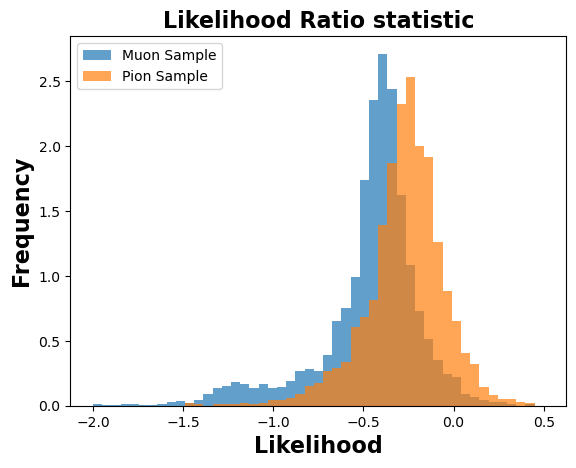

In [35]:
BINS=np.linspace(-2,0.5,50)
plt.hist(likeListmu, bins=BINS, label='Muon Sample', alpha=0.7, density=True)
plt.hist(likeListpi, bins=BINS, label='Pion Sample', alpha=0.7, density=True)
plt.legend()
plt.title('Likelihood Ratio statistic',fontsize=16,fontweight='bold')
plt.xlabel('Likelihood',fontsize=16,fontweight='bold')
plt.ylabel('Frequency',fontsize=16,fontweight='bold')

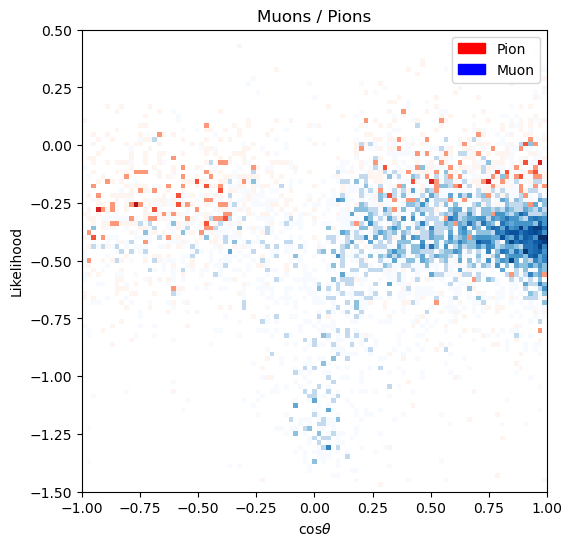

In [33]:
from matplotlib.patches import Patch

fig = plt.figure(figsize=(6,6))
BINS2D = (np.linspace(-1,1,100),np.linspace(-1.5,0.5,100))
plt.hist2d(PI_cos2,likeListpi,bins=BINS2D,cmap='Reds',norm=colors.LogNorm(), density=True)
plt.hist2d(MU_cos2,likeListmu,bins=BINS2D,cmap='Blues',norm=colors.LogNorm(), density=True)

legend_elements = [
    Patch(facecolor='red', edgecolor='r', label='Pion'),
    Patch(facecolor='blue', edgecolor='b', label='Muon')
]
plt.legend(handles=legend_elements)

plt.xlabel(r'cos$\theta$')
plt.ylabel('Likelihood')
plt.title('Muons / Pions')
plt.show()

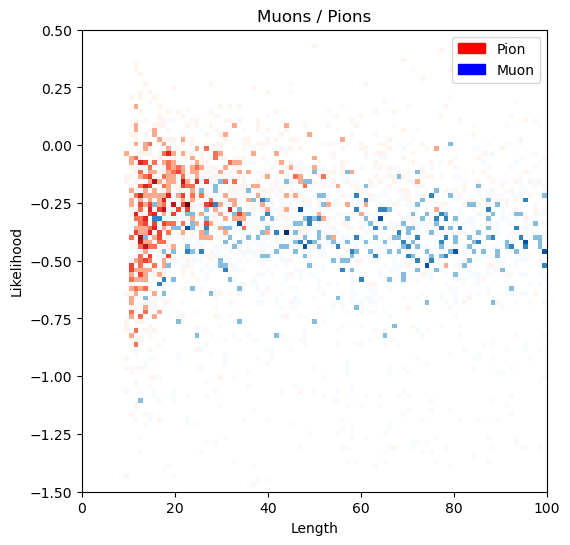

In [34]:
from matplotlib.patches import Patch

fig = plt.figure(figsize=(6,6))
BINS2D = (np.linspace(0,100,100),np.linspace(-1.5,0.5,100))
plt.hist2d(PI_length2,likeListpi,bins=BINS2D,cmap='Reds', norm=colors.LogNorm(), density=True)
plt.hist2d(MU_length2,likeListmu,bins=BINS2D,cmap='Blues', norm=colors.LogNorm(), density=True)

legend_elements = [
    Patch(facecolor='red', edgecolor='r', label='Pion'),
    Patch(facecolor='blue', edgecolor='b', label='Muon')
]
plt.legend(handles=legend_elements)

plt.xlabel('Length')
plt.ylabel('Likelihood')
plt.title('Muons / Pions')
plt.show()

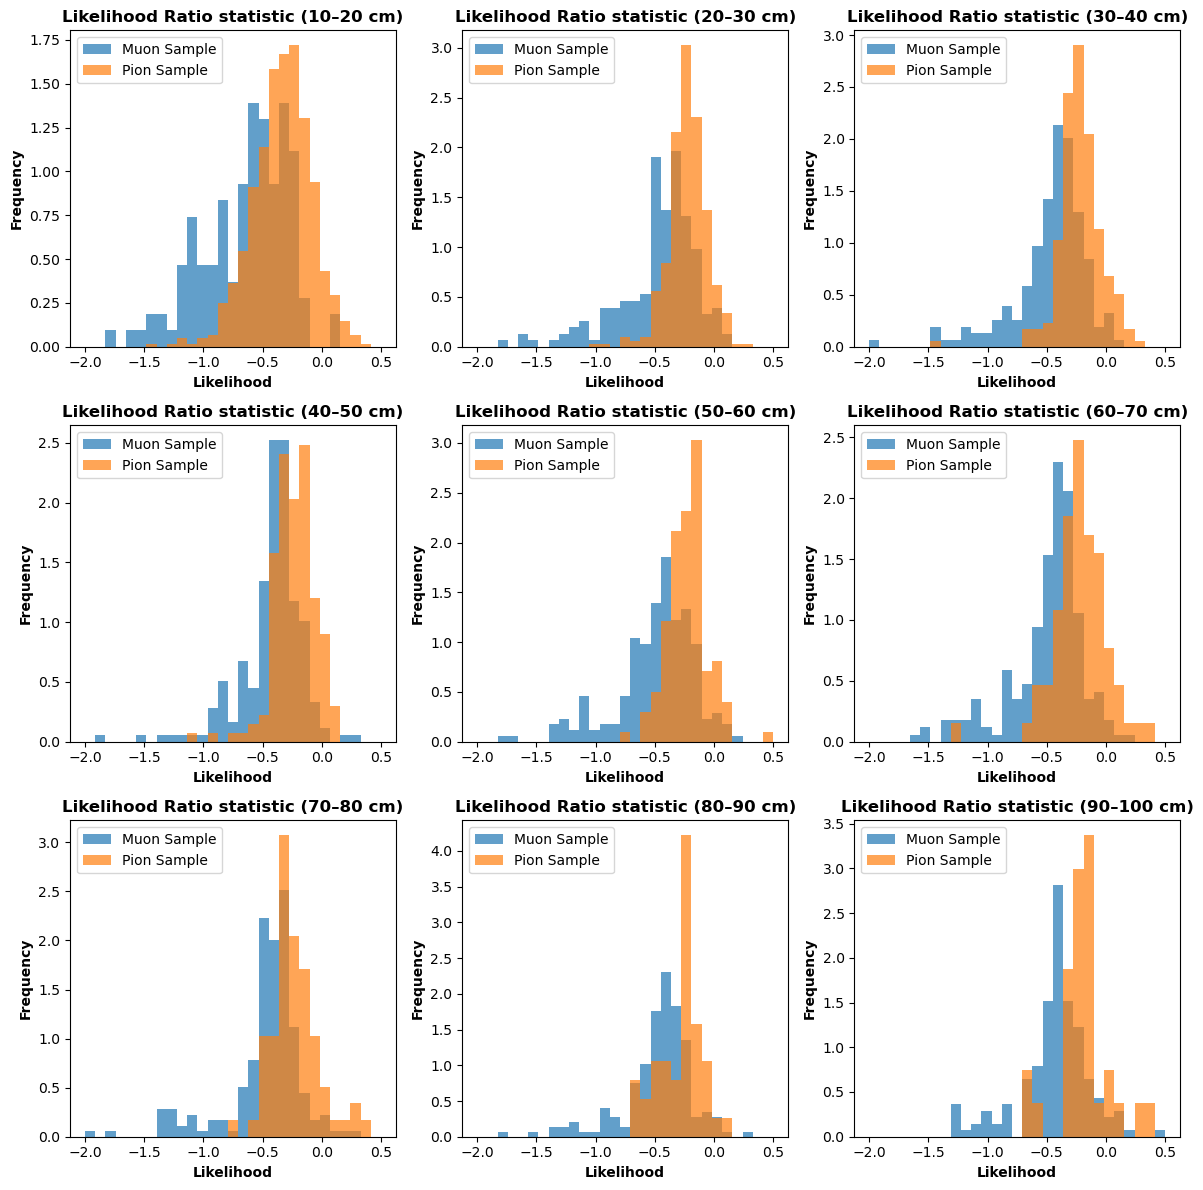

In [76]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

hist_i = 0
hist_j = 0
lw_lmt = 10
up_lmt = 20

while (up_lmt <= 100):
    temp_select_PI = np.where((PI_length2 > lw_lmt) & (PI_length2 <= up_lmt))[0]
    temp_select_MU = np.where((MU_length2 > lw_lmt) & (MU_length2 <= up_lmt))[0]
    
    BINS = np.linspace(-2, 0.5, 30)
    axes[hist_i, hist_j].hist(likeListmu[temp_select_MU], bins=BINS, label='Muon Sample', alpha=0.7, density=True)
    axes[hist_i, hist_j].hist(likeListpi[temp_select_PI], bins=BINS, label='Pion Sample', alpha=0.7, density=True)
    axes[hist_i, hist_j].legend()
    axes[hist_i, hist_j].set_title(f'Likelihood Ratio statistic ({lw_lmt}–{up_lmt} cm)', fontsize=12, fontweight='bold')
    axes[hist_i, hist_j].set_xlabel('Likelihood', fontsize=10, fontweight='bold')
    axes[hist_i, hist_j].set_ylabel('Frequency', fontsize=10, fontweight='bold')

    hist_j += 1
    if (hist_j==3):
        hist_i += 1
        hist_j = 0
    lw_lmt += 10
    up_lmt += 10

plt.tight_layout()

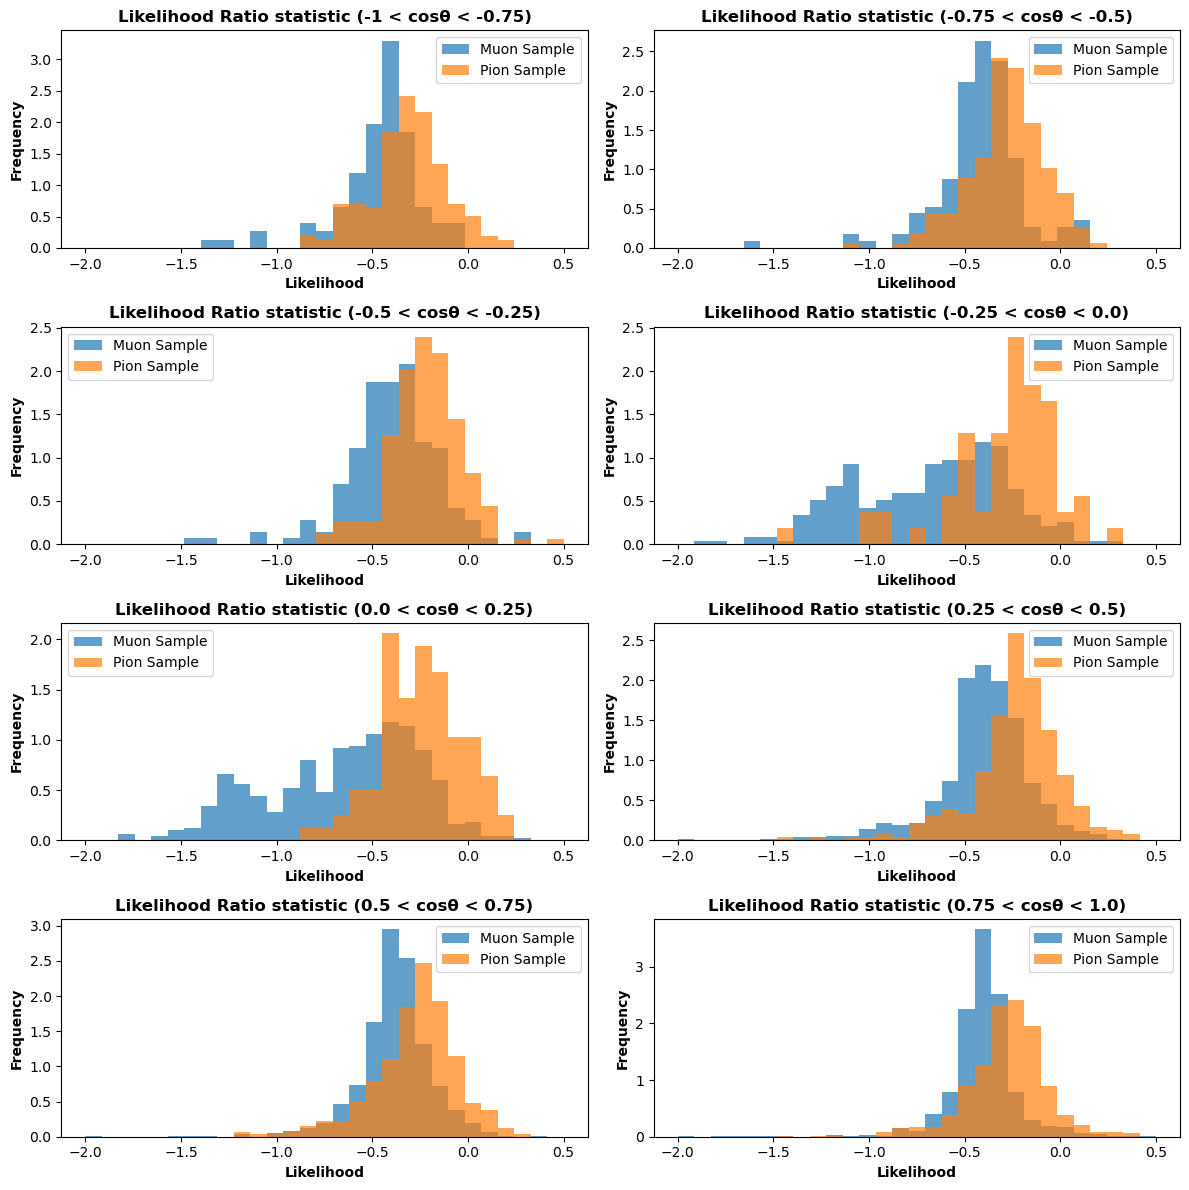

In [74]:
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

hist_i = 0
hist_j = 0
lw_lmt = -1
up_lmt = -0.75

while (up_lmt <= 1):
    temp_select_PI = np.where((PI_cos2 > lw_lmt) & (PI_cos2 <= up_lmt))[0]
    temp_select_MU = np.where((MU_cos2 > lw_lmt) & (MU_cos2 <= up_lmt))[0]
    
    BINS = np.linspace(-2, 0.5, 30)
    axes[hist_i, hist_j].hist(likeListmu[temp_select_MU], bins=BINS, label='Muon Sample', alpha=0.7, density=True)
    axes[hist_i, hist_j].hist(likeListpi[temp_select_PI], bins=BINS, label='Pion Sample', alpha=0.7, density=True)
    axes[hist_i, hist_j].legend()
    axes[hist_i, hist_j].set_title(f'Likelihood Ratio statistic ({lw_lmt} < cosθ < {up_lmt})', fontsize=12, fontweight='bold')
    axes[hist_i, hist_j].set_xlabel('Likelihood', fontsize=10, fontweight='bold')
    axes[hist_i, hist_j].set_ylabel('Frequency', fontsize=10, fontweight='bold')

    hist_j += 1
    if (hist_j==2):
        hist_i += 1
        hist_j = 0
    lw_lmt += 0.25
    up_lmt += 0.25

plt.tight_layout()